---

## Imports

In [5]:
import numpy as np 
from pathlib import Path 
import xarray as xr 
import tobac 
print('For this cookbook, we are using tobac version:', tobac.__version__)

For this cookbook, we are using tobac version: 1.6.0


## Look at the distribution to verify that thresholds make sense

In [33]:
# read in the regridded data 
mpas_regridded = xr.open_dataset("mpas_ice_water_path_regridded.nc")
iwp = mpas_regridded.ice_water_path.squeeze().compute() / 1000

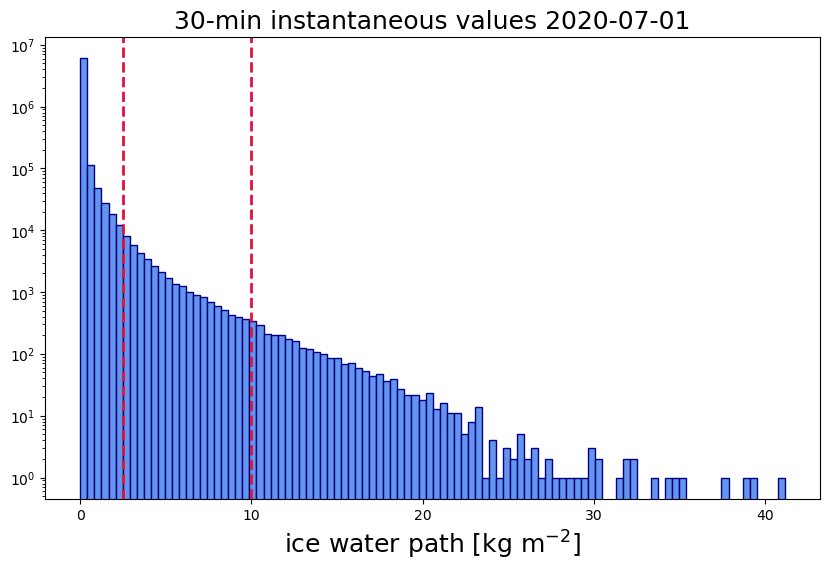

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

fs = 18
plt.title('30-min instantaneous values ' + str('2020-07-01'), fontsize = fs)
plt.hist(iwp.values.flatten(), bins=100, log=True, color='cornflowerblue', edgecolor='navy')

thresholds = [2.5, 10]
for threshold in thresholds:
    plt.axvline(x=threshold, color='crimson', linestyle='--', linewidth=2, label='Threshold' + str(threshold))

plt.xlabel('ice water path [kg m$^{-2}$]', fontsize = fs )
plt.show()

## Feature detection

In [25]:
# set horizontal grid spacing [m] and temporal resolution [s]
dxy,dt= 14000, 3600 

# parameters for feature detection                                                           
parameters_features = {}
parameters_features['threshold']=[2.5, 10]  # thresholds for ice water path 
parameters_features['target']='maximum'
parameters_features['n_min_threshold']= 100  # minimum number of grid cells that need to be above specified threshold 

In [34]:
mpas_regridded.ice_water_path / 1000

<xarray.DataArray 'ice_water_path' (time: 1, lat: 1801, lon: 3601)> Size: 26MB
array([[[0.00522107, 0.00522107, 0.00522107, ..., 0.00522107,
         0.00522107, 0.00522107],
        [0.00449405, 0.00449405, 0.00449405, ..., 0.00421795,
         0.00421795, 0.00449405],
        [0.00329704, 0.00329704, 0.00329704, ..., 0.00329704,
         0.00329704, 0.00329704],
        ...,
        [0.00338675, 0.00338675, 0.00338675, ..., 0.00338675,
         0.00338675, 0.00338675],
        [0.00929644, 0.00929644, 0.00929644, ..., 0.01516151,
         0.01516151, 0.00929644],
        [0.01638432, 0.01638432, 0.01638432, ..., 0.01638432,
         0.01638432, 0.01638432]]], shape=(1, 1801, 3601), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2020-07-01
  * lat      (lat) float64 14kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float64 29kB 0.0 0.1 0.2 0.3 0.4 ... 359.7 359.8 359.9 360.0

In [35]:
%%time 
input_data = mpas_regridded.ice_water_path / 1000
storm_features = tobac.feature_detection_multithreshold(input_data, dxy, **parameters_features)

CPU times: user 308 ms, sys: 52.4 ms, total: 361 ms
Wall time: 5.19 s


## Segmentation 

In this step, we can calculate some bulk metrics for the storm objects detected in each timestep. 

In [36]:
# parameters for segmentation 
parameters_segmentation = {}
parameters_segmentation['threshold']= 0.25 # kg/m2 used to define the extent of the cloud objects                     
parameters_segmentation['target'] = "maximum"
parameters_segmentation['statistic'] = {"max_iwp": np.nanmax, 'total_iwp': np.nansum, 'mean_iwp': np.nanmean}

In [37]:
%%time 
mask, storm_features = tobac.segmentation_2D(storm_features, input_data, dxy, **parameters_segmentation)

/Users/kukulies/miniconda3/envs/storm-tracking-cookbook-dev/lib/python3.10/site-packages/tobac/segmentation/watershed_segmentation.py:1264: UserWarning: As of v1.6.0, segmentation with time length 1 will return time as a coordinate instead of dropping it (i.e., output will now be 1xMxN instead of MxN). 
  warnings.warn(


CPU times: user 337 ms, sys: 75.9 ms, total: 413 ms
Wall time: 2.84 s


In [42]:
storm_features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,ncells,max_iwp,total_iwp,mean_iwp
0,0,6,245.846995,445.827869,366,2.5,1,2020-07-01,2020-07-01 00:00:00,-65.415301,44.582787,8477,3.809041,9605.705078,1.133149
1,0,9,258.608273,450.554745,411,2.5,2,2020-07-01,2020-07-01 00:00:00,-64.139173,45.055474,14459,5.30629,15411.644531,1.065886
2,0,47,365.550708,3353.379717,1696,2.5,3,2020-07-01,2020-07-01 00:00:00,-53.444929,335.337972,19347,7.36197,24867.107422,1.285321
3,0,162,413.284672,1121.408759,137,2.5,4,2020-07-01,2020-07-01 00:00:00,-48.671533,112.140876,1061,15.502665,2302.708984,2.17032
4,0,300,456.368794,1035.709220,141,2.5,5,2020-07-01,2020-07-01 00:00:00,-44.363121,103.570922,640,14.452993,1586.196289,2.478432


### Computation of storm statistics 

One big advantage of global model data are the physically consistent fields. We can use **tobac** to calculate additional bulk statistics for the detected storm objects using other fields of the model data. 

In this example, we explore what the surface precipitation (*rainnc*) and liquid water path (*liquid_water_path*) are for the ice water path-based detected clouds. These two fields will tell us more about whether and how much it is raining underneath a cloud that produces lots of cloud ice and how the total amount of liquid condensate is related to the total amount of frozen condensate. 

In [13]:
# calculate statistics based on additional variables 
storm_features= tobac.utils.bulk_statistics.get_statistics_from_mask(
    storm_features, mask, mpas_regridded.liquid_water_path / 1000, statistic={"max_lwp": np.nanmax, "mean_lwp": np.nanmean, "total_lwp": np.nansum}, default=np.nan) 

storm_features = tobac.utils.bulk_statistics.get_statistics_from_mask(
    storm_features, mask, mpas_regridded.rainnc , statistic={"max_precip": np.nanmax, "mean_precip": np.nanmean, "total_precip": np.nansum}, default=np.nan) 

/glade/work/kukulies/conda-envs/easypeasy/lib/python3.12/site-packages/tobac/utils/bulk_statistics.py:340: UserWarning: Not all timesteps have matching features
  warnings.warn("Not all timesteps have matching features", UserWarning)
/glade/work/kukulies/conda-envs/easypeasy/lib/python3.12/site-packages/tobac/utils/bulk_statistics.py:340: UserWarning: Not all timesteps have matching features
  warnings.warn("Not all timesteps have matching features", UserWarning)


In [38]:
# save features
storm_features.to_xarray().to_netcdf('iwp_lwp_precip_features.nc')

## Tracking

In [44]:
# parameters for linking 
parameters_linking={}
parameters_linking['v_max']= 50
parameters_linking['stubs']= 1 
parameters_linking['method_linking']= 'predict'
parameters_linking['PBC_flag'] ="hdim_2"
parameters_linking['min_h2'] = 0 
parameters_linking['max_h2'] = mpas_regridded.lon.size

In [48]:
Tracks = tobac.linking_trackpy(storm_features, None, dt=dt, dxy=dxy, **parameters_linking)

In [47]:
Tracks.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,ncells,max_iwp,total_iwp,mean_iwp,cell,time_cell
0,0,6,245.846995,445.827869,366,2.5,1,2020-07-01,2020-07-01 00:00:00,-65.415301,44.582787,8477,3.809041,9605.705078,1.133149,1,0 days
1,0,9,258.608273,450.554745,411,2.5,2,2020-07-01,2020-07-01 00:00:00,-64.139173,45.055474,14459,5.30629,15411.644531,1.065886,2,0 days
2,0,47,365.550708,3353.379717,1696,2.5,3,2020-07-01,2020-07-01 00:00:00,-53.444929,335.337972,19347,7.36197,24867.107422,1.285321,3,0 days
3,0,162,413.284672,1121.408759,137,2.5,4,2020-07-01,2020-07-01 00:00:00,-48.671533,112.140876,1061,15.502665,2302.708984,2.17032,4,0 days
4,0,300,456.368794,1035.709220,141,2.5,5,2020-07-01,2020-07-01 00:00:00,-44.363121,103.570922,640,14.452993,1586.196289,2.478432,5,0 days


---